# Alignment Under Use: Human-LLM Interaction in the Wild
## Analysis Notebook

This notebook provides the analysis and visualizations for the study on conversational alignment in human-ChatGPT interactions. It is structured by research questions and exploratory analyses.

### 0. Data Preparation
Loading and cleaning the turn-level dataset.

In [1]:
import os
# Disable the C++ compiler entirely to avoid Cygwin conflicts
os.environ["PYTENSOR_FLAGS"] = "cxx=" 
# Set the linker to the Python-based one
os.environ["PYTENSOR_LINKER"] = "py" 

import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import bambi as bmb

In [2]:
# Set style
sns.set_theme(style='whitegrid')

# Load data
df = pd.read_csv('../../data/outputs/merged.csv')
metrics = ['lexical_jaccard', 'pos_jaccard', 'lsm_score', 'semantic_similarity', 'sentiment_similarity']

# Clean missing values
df_clean = df.dropna(subset=metrics + ['combined_topic_id', 'direction']).copy()
df_clean['abs_turn'] = df_clean['turn'].abs()

print(f'Data loaded: {len(df_clean)} turns.')

Data loaded: 72139 turns.


### 0.1 Data filtering 

In [3]:
# Data filtering heuristics

# 1. Filter conversations with ≥2 turns and ≤95th percentile length
conv_lengths = df_clean.groupby('conv_id')['turn'].count()
valid_convs = conv_lengths[(conv_lengths >= 2) & (conv_lengths <= conv_lengths.quantile(0.95))].index
df_filtered = df_clean[df_clean['conv_id'].isin(valid_convs)].copy()

# 2. Exchange-level turn pairs: shared exchange index = |turn|
df_filtered['abs_turn'] = df_filtered['turn'].abs()

# 3. Support threshold: keep only abs_turns with n ≥ 200 conversations
turn_counts = df_filtered.groupby('abs_turn')['conv_id'].nunique()
valid_turns = turn_counts[turn_counts >= 200].index
df_filtered = df_filtered[df_filtered['abs_turn'].isin(valid_turns)].copy()

In [4]:
# Re-create topic labels after filtering
topic_info = df_filtered.groupby('combined_topic_id').agg({'combined_keywords': 'first', 'conv_id': 'nunique'})
label_map = {tid: f"{', '.join(str(row['combined_keywords']).split(' / ')[:2])} (n={row['conv_id']})"
             for tid, row in topic_info.iterrows()}
df_filtered['topic_label'] = df_filtered['combined_topic_id'].map(label_map)

### RQ1: How do shared human-ChatGPT conversations vary across topics in the degree of alignment?
Analyzing mean alignment scores across all 30 identified topics with error bars (95% CI).

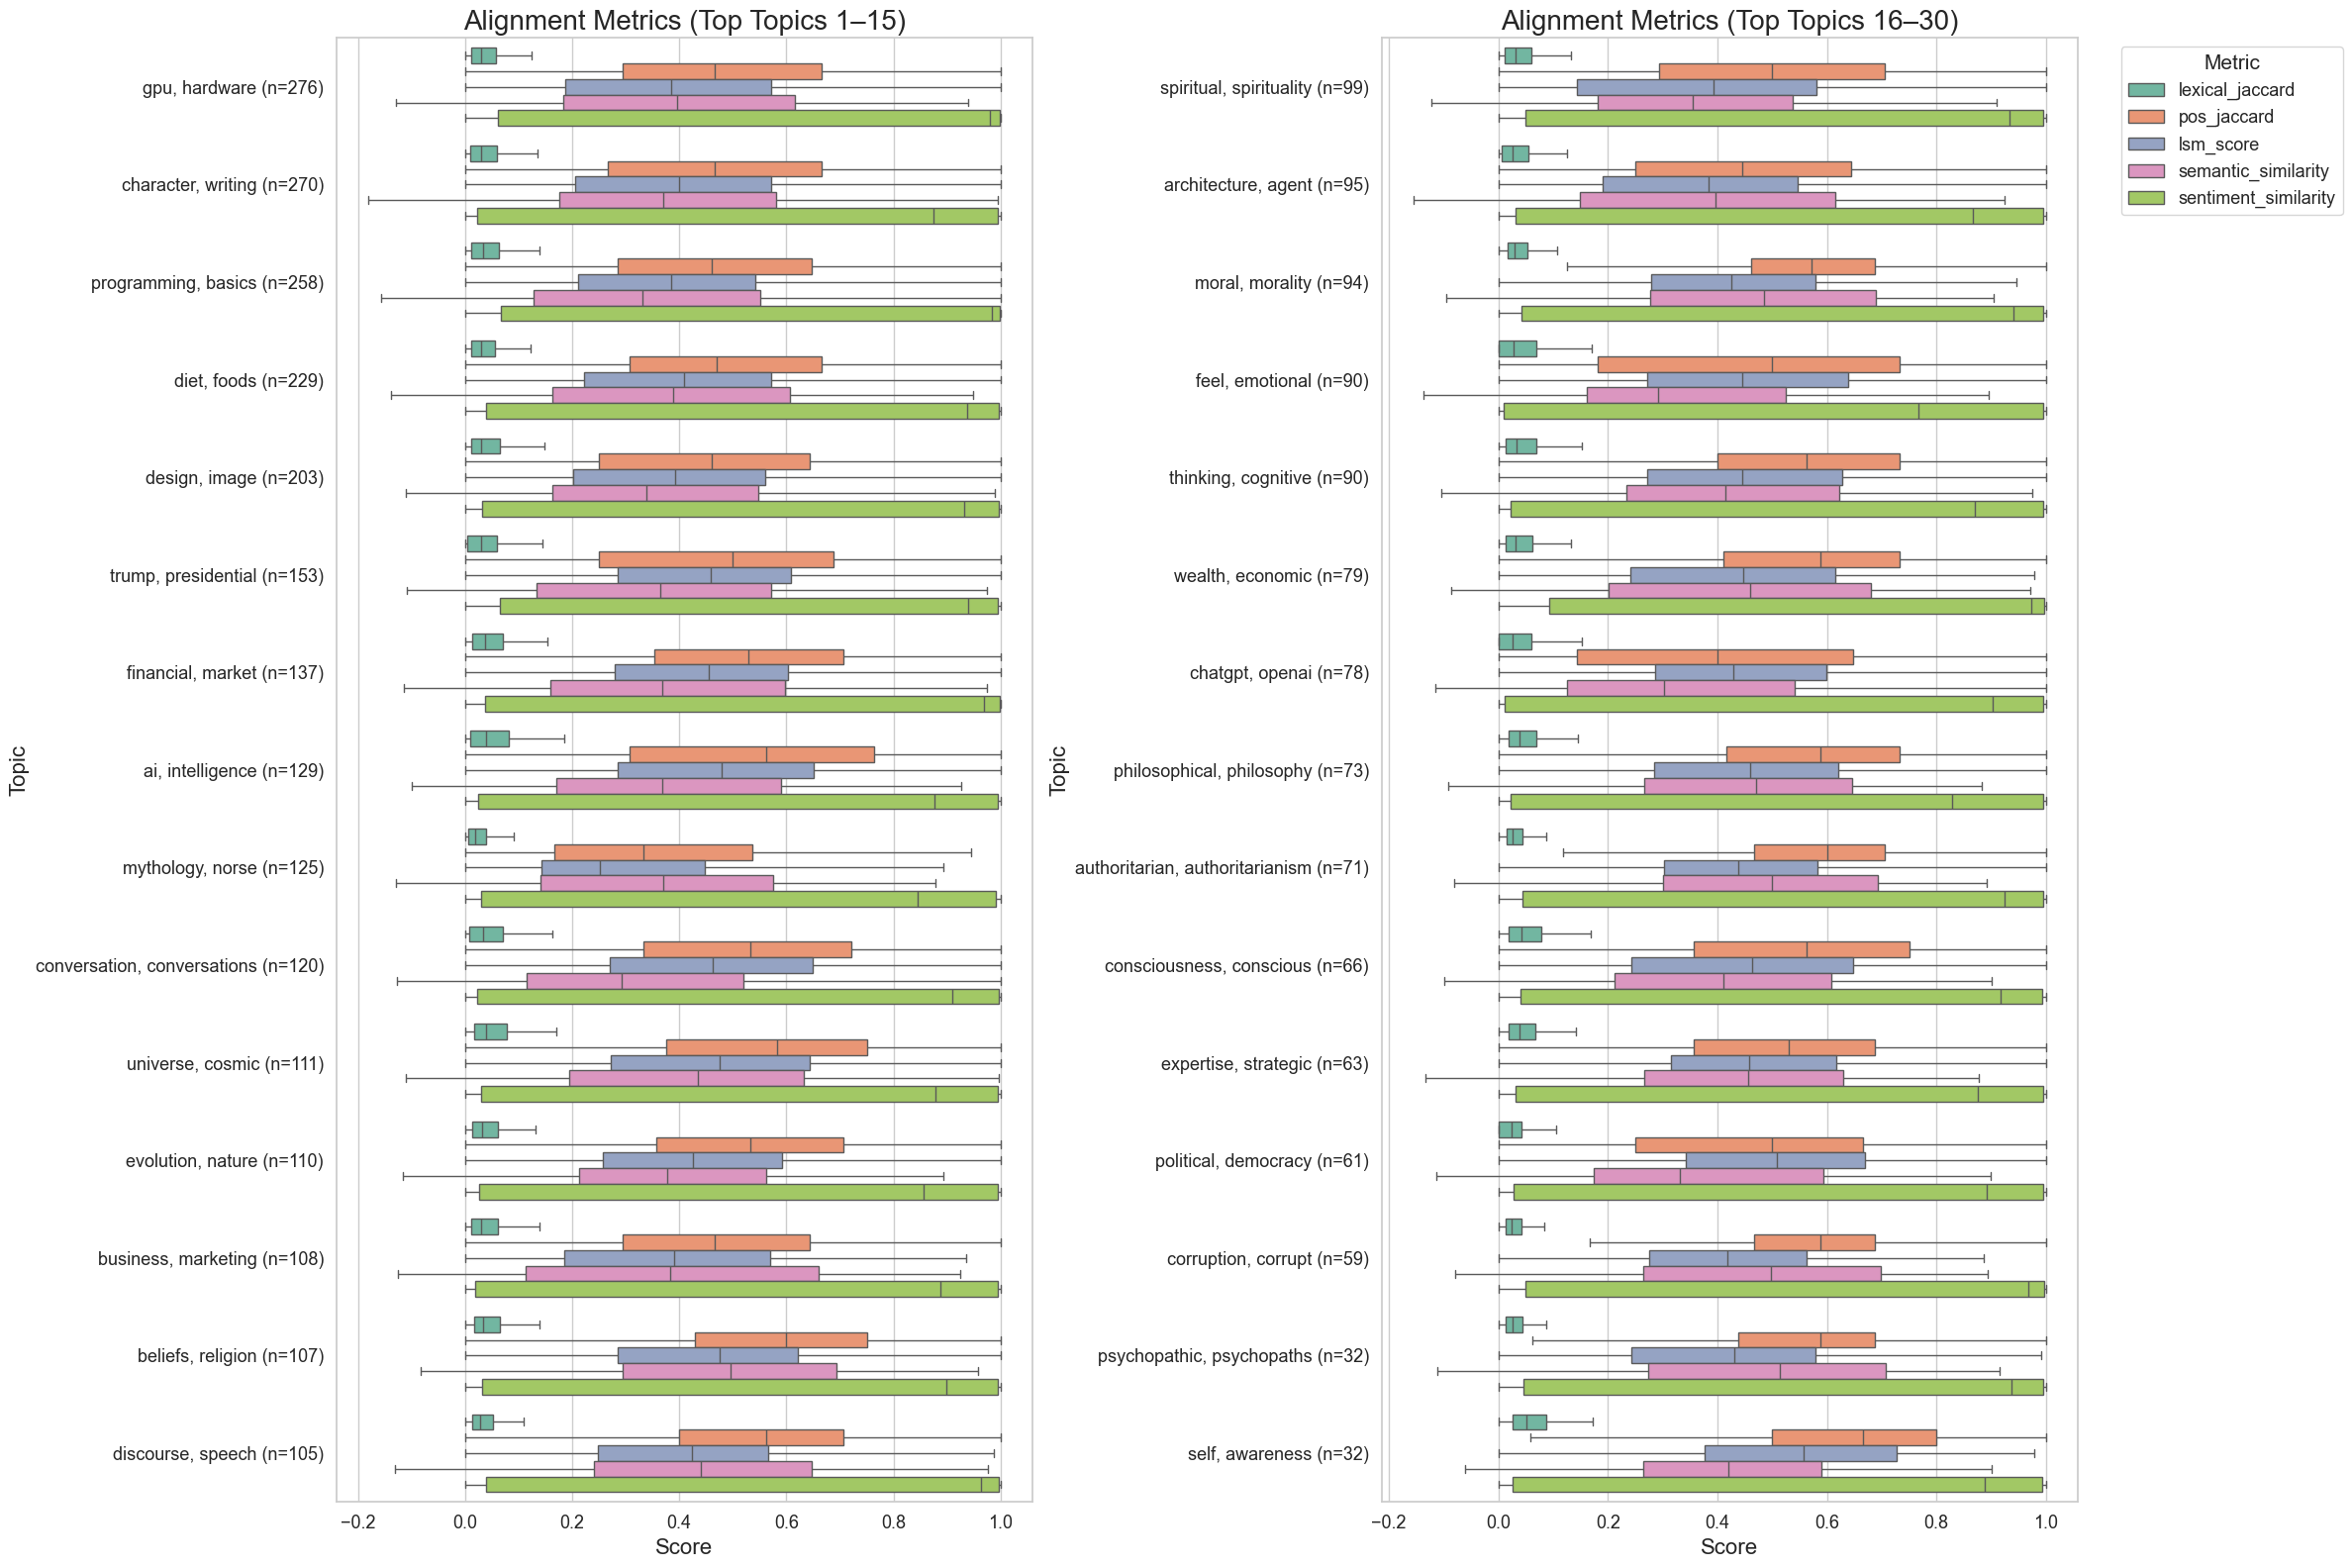

In [5]:
# Ensure you have the topic order and splits
topic_info = df_clean.groupby('combined_topic_id').agg({'combined_keywords': 'first', 'conv_id': 'nunique'})
label_map = {tid: f"{', '.join(str(row['combined_keywords']).split(' / ')[:2])} (n={row['conv_id']})"
             for tid, row in topic_info.iterrows()}
df_clean['topic_label'] = df_clean['combined_topic_id'].map(label_map)
ordered_labels = [label_map[tid] for tid in topic_info.sort_values('conv_id', ascending=False).index]
first_15 = ordered_labels[:15]
second_15 = ordered_labels[15:]

# Melt for boxplot
topic_melted = df_clean.melt(id_vars=['topic_label'], value_vars=metrics, var_name='Metric', value_name='Score')

# Plot: two boxplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 16), sharey=False)

# Left: first 15 topics
sns.boxplot(
    data=topic_melted[topic_melted['topic_label'].isin(first_15)],
    x='Score', y='topic_label', hue='Metric',
    order=first_15,
    palette='Set2',
    dodge=True,
    showfliers=False,
    ax=axes[0]
)
axes[0].set_title('Alignment Metrics (Top Topics 1–15)', fontsize=20)
axes[0].set_xlabel('Score', fontsize=16)
axes[0].set_ylabel('Topic', fontsize=16)
axes[0].tick_params(axis='y', labelsize=13)
axes[0].tick_params(axis='x', labelsize=13)
axes[0].legend_.remove()  # Remove legend from left plot

# Right: next 15 topics
sns.boxplot(
    data=topic_melted[topic_melted['topic_label'].isin(second_15)],
    x='Score', y='topic_label', hue='Metric',
    order=second_15,
    palette='Set2',
    dodge=True,
    showfliers=False,
    ax=axes[1]
)
axes[1].set_title('Alignment Metrics (Top Topics 16–30)', fontsize=20)
axes[1].set_xlabel('Score', fontsize=16)
axes[1].set_ylabel('Topic', fontsize=16)
axes[1].tick_params(axis='y', labelsize=13)
axes[1].tick_params(axis='x', labelsize=13)
axes[1].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, title_fontsize=15)

plt.tight_layout()
plt.show()

### RQ2: How do these alignment dimensions evolve over the course of a conversation?
Comparing the temporal dynamics for both directions (User->Assistant vs Assistant->User) with a sample filter (N >= 200 conversations).

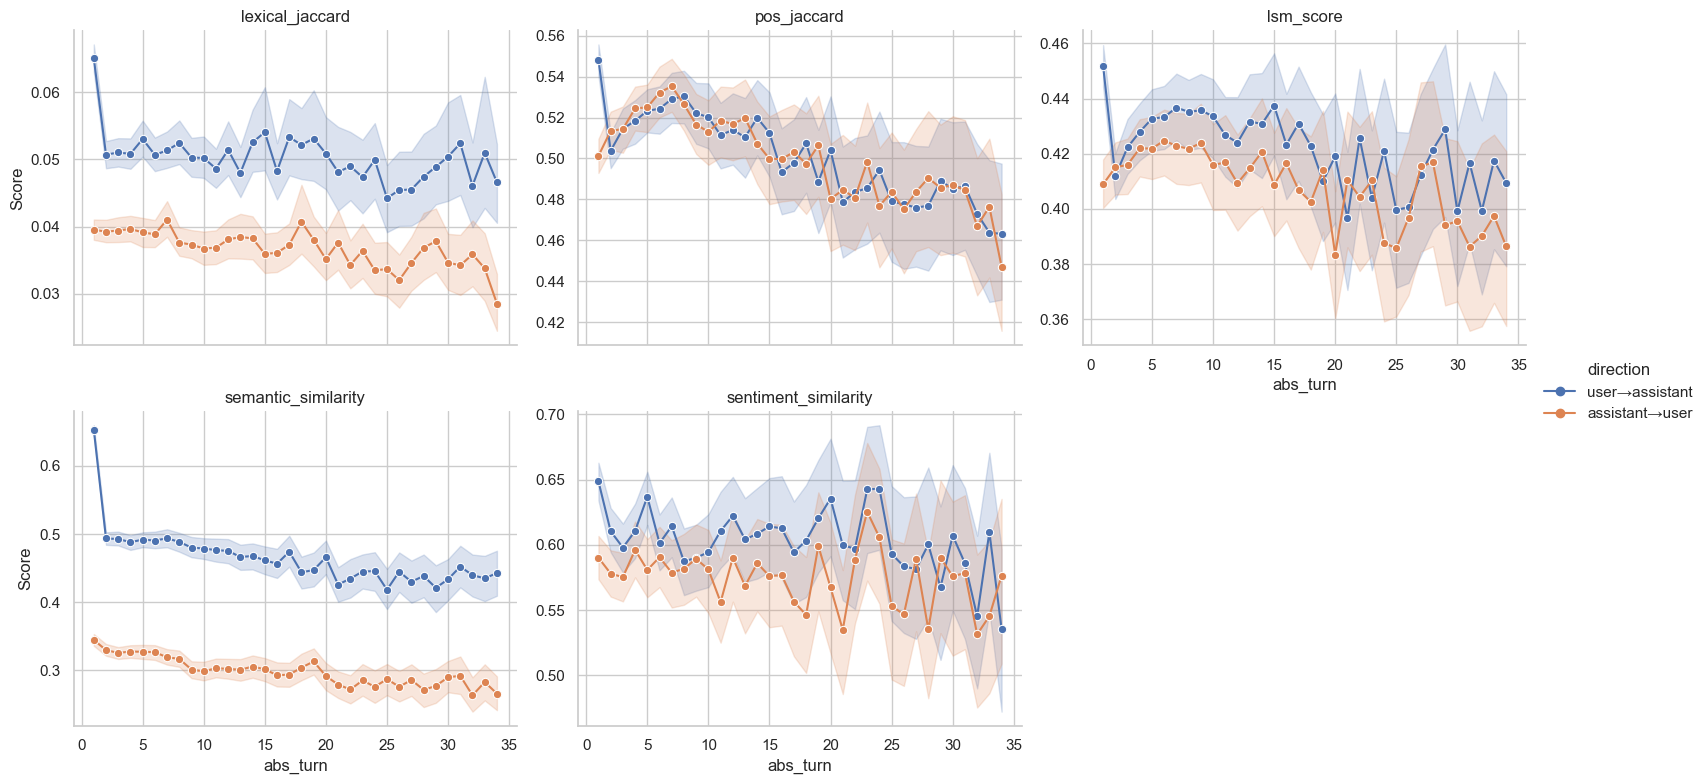

Total rows: 38875
Unique conv_ids: 2647
Average rows per conv_id: 14.686437476388365


In [6]:
# Filter turns with N >= 200 unique conversations
turn_counts = df_clean.groupby('abs_turn')['conv_id'].nunique()
valid_turns = turn_counts[turn_counts >= 200].index.tolist()
df_temporal = df_clean[df_clean['abs_turn'].isin(valid_turns)].copy()

# Melt
temporal_melted = df_temporal.melt(id_vars=['abs_turn', 'direction'], value_vars=metrics, var_name='Metric', value_name='Score')

# Plot
g = sns.relplot(
    data=temporal_melted, x="abs_turn", y="Score", hue="direction", 
    col="Metric", col_wrap=3, kind="line", marker="o", 
    errorbar=("ci", 95), height=4, aspect=1.3, facet_kws={'sharey': False}
)
g.set_titles("{col_name}")
plt.show()

print(f"Total rows: {len(df_filtered)}")
print(f"Unique conv_ids: {df_filtered['conv_id'].nunique()}")
print(f"Average rows per conv_id: {len(df_filtered) / df_filtered['conv_id'].nunique()}")

### RQ3: Under what conditions does alignment shift toward excessive convergence (Sycophancy)?
Analyzing the 90th percentile of Semantic Similarity and the impact of Custom Instructions.

C:\Users\szh\AppData\Local\Temp\ipykernel_36680\2403362216.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ua['has_custom_instructions'] = df_ua['has_custom_instructions'].fillna(False).astype(bool)
C:\Users\szh\AppData\Local\Temp\ipykernel_36680\2403362216.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_exc.values, y=topic_exc.index, palette='magma')


Proportion of excessive alignment with Custom Instructions:
has_custom_instructions
False    0.177274
True     0.171109
Name: is_excessive, dtype: float64


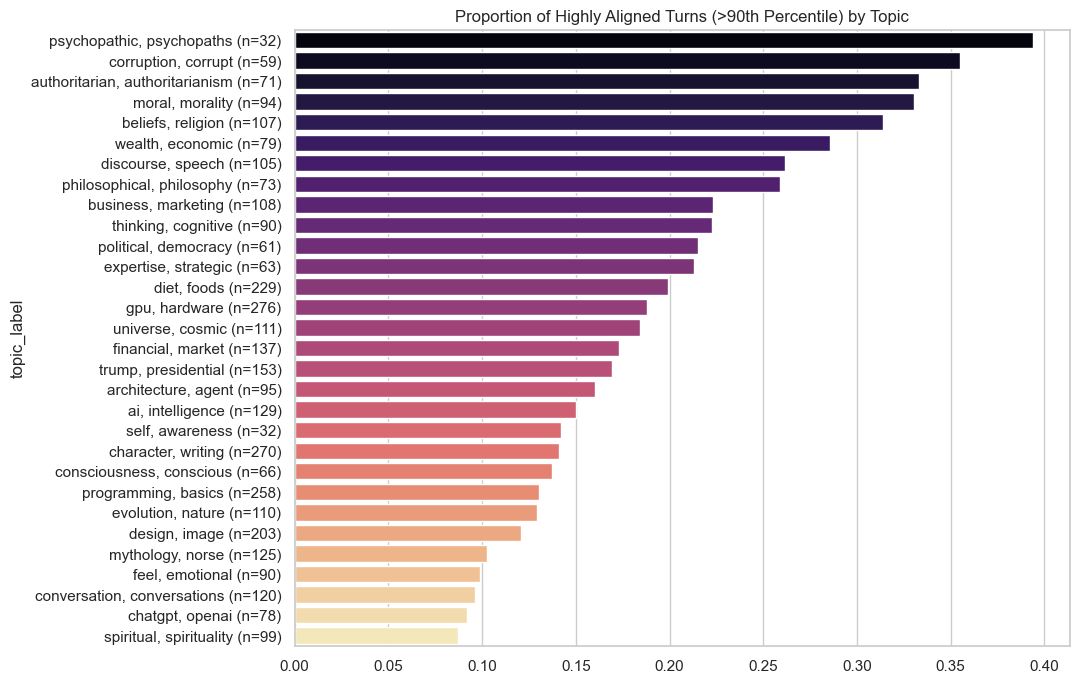

In [10]:
# Define excessive alignment (top 10%)
threshold = df_clean['semantic_similarity'].quantile(0.9)
df_clean['is_excessive'] = df_clean['semantic_similarity'] > threshold

# 1. Impact of Custom Instructions (User->Assistant only)
df_ua = df_clean[df_clean['direction'] == 'user→assistant'].copy()
df_ua['has_custom_instructions'] = df_ua['has_custom_instructions'].fillna(False).astype(bool)
ci_stats = df_ua.groupby('has_custom_instructions')['is_excessive'].mean()
print(f"Proportion of excessive alignment with Custom Instructions:\n{ci_stats}")

# 2. Excessive Alignment by Topic
topic_exc = df_ua.groupby('topic_label')['is_excessive'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=topic_exc.values, y=topic_exc.index, palette='magma')
plt.title("Proportion of Highly Aligned Turns (>90th Percentile) by Topic")
plt.show()

### Further Exploration: Model Families, Custom GPTs, and Breakdown/Repair
Deep dive into how specialized configurations affect interactional dynamics.

In [14]:
#list unique models in the data
df_ua['model_slug'].nunique()
df_ua['model_slug'].unique()

array(['gpt-5-1', 'gpt-5-t-mini', nan, 'gpt-5-1-thinking', 'gpt-5-mini',
       'gpt-5', 'gpt-4o', 'research', 'gpt-5-1-instant', 'gpt-5-thinking',
       'text-davinci-002-render-sha', 'gpt-5-pro', 'gpt-4-1-mini',
       'gpt-5-instant', 'gpt-4-1', 'gpt-4o-mini', 'o4-mini',
       'gpt-5-a-t-mini', 'gpt-5-auto-thinking', 'o3', 'gpt-4', 'o1',
       'gpt-4-5', 'o4-mini-high', 'o3-mini', 'o3-mini-high', 'o1-pro',
       'gpt-4o-jawbone', 'o1-mini', 'o1-preview', 'gpt-4o-canmore',
       'gpt-5-2', 'gpt-5-2-thinking', 'gpt-5-2-instant'], dtype=object)

C:\Users\szh\AppData\Local\Temp\ipykernel_36680\3588535924.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


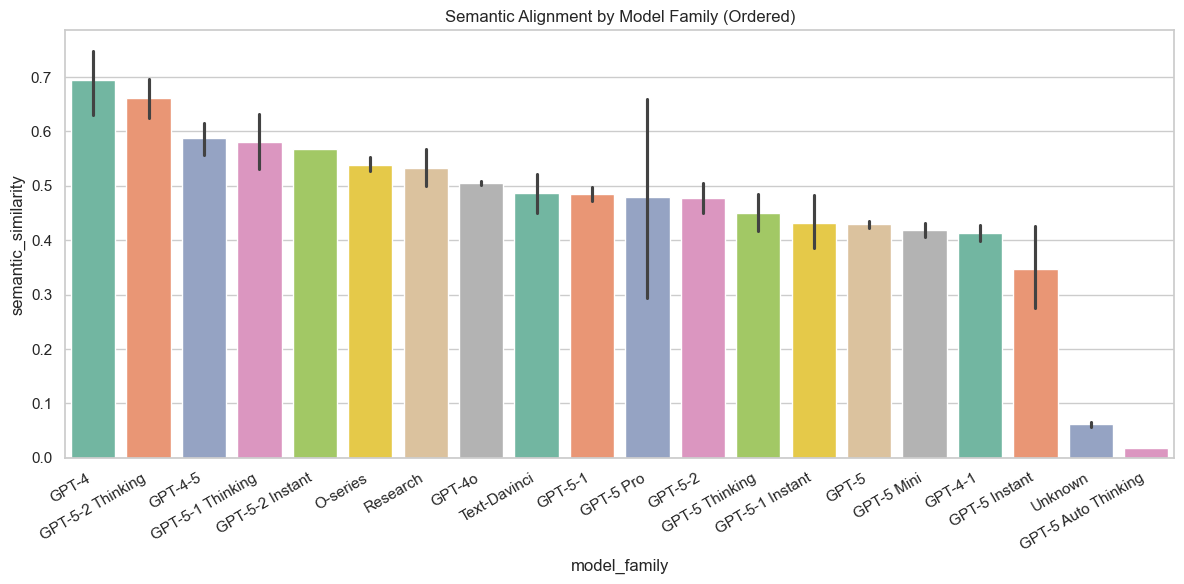

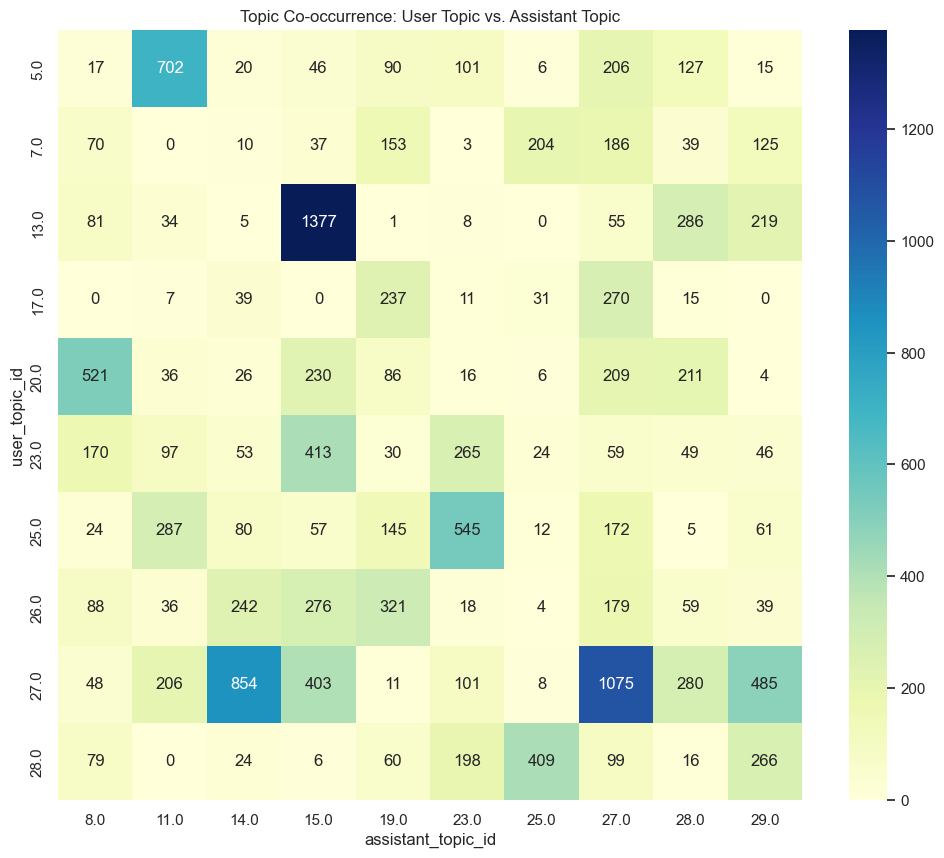

In [19]:
# Compute mean semantic similarity by model family and sort
order = (
    df_ua.groupby("model_family")["semantic_similarity"]
    .mean()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_ua,
    x="model_family",
    y="semantic_similarity",
    palette="Set2",
    order=order
)
plt.title("Semantic Alignment by Model Family (Ordered)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# 2. Topic Matching Heatmap (User vs Assistant perception)
cols = ['user_topic_id', 'assistant_topic_id', 'user_keywords', 'assistant_keywords']
df_topics = df_ua.dropna(subset=cols).copy()

# Take top 10 most frequent pairings
top_u = df_topics['user_topic_id'].value_counts().nlargest(10).index
top_a = df_topics['assistant_topic_id'].value_counts().nlargest(10).index
df_sub = df_topics[df_topics['user_topic_id'].isin(top_u) & df_topics['assistant_topic_id'].isin(top_a)]

heatmap_data = pd.crosstab(df_sub['user_topic_id'], df_sub['assistant_topic_id'])
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Topic Co-occurrence: User Topic vs. Assistant Topic")
plt.show()

### Statistical Validation
Running a Mixed-Effects Model to validate the influence of Topic on Semantic Alignment.

In [9]:
# Model: semantic ~ topic + (1|conv_id)
df_stats = df_ua.dropna(subset=['semantic_similarity', 'combined_topic_id', 'conv_id']).copy()
df_stats = df_stats.rename(columns={'semantic_similarity': 'semantic', 'combined_topic_id': 'topic', 'conv_id': 'conv'})

try:
    md = smf.mixedlm("semantic ~ C(topic)", df_stats, groups=df_stats["conv"])
    mdf = md.fit()
    print(mdf.summary())
except Exception as e:
    print(f"Model fitting failed: {e}")

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  semantic 
No. Observations:   37310    Method:              REML     
No. Groups:         3450     Scale:               0.0459   
Min. group size:    1        Log-Likelihood:      2547.2276
Max. group size:    766      Converged:           Yes      
Mean group size:    10.8                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.537    0.027 19.722 0.000  0.484  0.591
C(topic)[T.1.0]   0.073    0.032  2.261 0.024  0.010  0.137
C(topic)[T.2.0]  -0.035    0.031 -1.126 0.260 -0.095  0.026
C(topic)[T.3.0]   0.057    0.031  1.819 0.069 -0.004  0.119
C(topic)[T.4.0]  -0.026    0.033 -0.799 0.424 -0.091  0.038
C(topic)[T.5.0]  -0.074    0.031 -2.440 0.015 -0.134 -0.015
C(topic)[T.6.0]   0.051    0.031  1.644 0.100 -0.01